In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
import argparse
from scipy.misc import imread, imresize
from PIL import Image


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load('checkpoint_coco_5_cap_per_img_5_min_word_freq.pth.tar', map_location='cpu')
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()

with open('../data/WORDMAP_coco_5_cap_per_img_5_min_word_freq.json', 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

In [3]:
image_path = './COCO_val2014_000000000074.jpg'
beam_size = 3

In [4]:
# seq, alphas = caption_image_beam_search(encoder, decoder, args.img, word_map, args.beam_size)
k = beam_size
vocab_size = len(word_map)
img = imread(image_path)
if len(img.shape) == 2:
    img = img[:, :, np.newaxis]
    img = np.concatenate([img, img, img], axis=2)
img = imresize(img, (256, 256))
img = img.transpose(2, 0, 1)
img = img / 255.
img = torch.FloatTensor(img).to(device)
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])
# transform = transforms.Compose([normalize])
# img = transform(img)  # (3, 256, 256)
# Encode
image = img.unsqueeze(0)  # (1, 3, 256, 256)
encoder_out = encoder(image)
enc_image_size = encoder_out.size(1)
encoder_dim = encoder_out.size(-1)
encoder_out = encoder_out.view(1, -1, encoder_dim)
num_pixels = encoder_out.size(1)
# We'll treat the problem as having a batch size of k`
encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)
# Tensor to store top k previous words at each step; now they're just <start>`
k_prev_words = torch.LongTensor([[word_map["<start>"]]] * k).to(device)  # (k, 1)
# Tensor to store top k sequences; now they're just <start>`
seqs = k_prev_words  # (k, 1)
# Tensor to store top k sequences' scores; now they're just 0`
top_k_scores = torch.zeros([k, 1]).to(device)  # (k, 1)
# Lists to store completed sequences, their alphas and scores
complete_seqs = list()
# complete_seqs_alpha = list()
complete_seqs_scores = list()
# Decode
step = 1
h, c = decoder.init_hidden_state(encoder_out)  # (3, decoder_dim)
# Iterate until all k sequences are completed
while True:
    # Compute scores of current k previous words
    embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (k, 1, embed_dim) to (k, embed_dim)
    h, c = decoder.decode_step(
            embeddings,  # (3, embed_dim)
            (h, c))  # (3, decoder_dim)
    scores = decoder.fc(h)
    scores = F.log_softmax(scores, dim=1)
    scores = top_k_scores.expand_as(scores) + scores
    if step == 1:
        top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
    else:
        # Unroll and find top scores, and their unrolled indices
        top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)
    # Convert unrolled indices to actual indices of scores
    prev_word_inds = top_k_words / vocab_size  # (s)
    next_word_inds = top_k_words % vocab_size  # (s)
    # Add new words to sequences, alphas
    seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
    # Which sequences are incomplete (didn't reach <end>)?
    incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                       next_word != word_map['<end>']]
    complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))
    if len(complete_inds) > 0:
        complete_seqs.extend(seqs[complete_inds].tolist())
        complete_seqs_scores.extend(top_k_scores[complete_inds])
    k -= len(complete_inds)
    # Proceed with incomplete sequences
    if k == 0:
        break
    seqs = seqs[incomplete_inds]
    h = h[prev_word_inds[incomplete_inds]]
    c = c[prev_word_inds[incomplete_inds]]
    encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
    top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
    k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)
    # Break if things have been going on too long
    if step > 50:
        break
    step += 1


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [5]:
i = complete_seqs_scores.index(max(complete_seqs_scores))
seq = complete_seqs[i]

In [6]:
def visualize_att(image_path, seq, rev_word_map, smooth=True):
    """
    Visualizes caption with weights at every word.
    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb
    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]

    for t in range(len(words)):
        if t > 50:
            break
        plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)

        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()


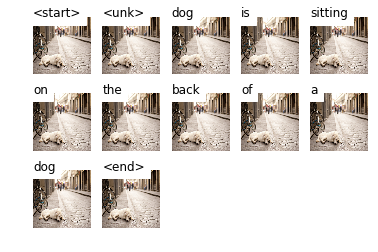

In [7]:
visualize_att(image_path, seq, rev_word_map)